<a href="https://colab.research.google.com/github/sheliak/klasifikacija_spektrov/blob/main/klasifikacija.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Klasifikacija zvezdnih spektrov s strojnim učenjem

Delavnica za tabor Gimnazije Bežigrad, junij 2023

Seznam poglavij:

 - [Spoznajmo spektre](#spoznajmo-spektre)
 - [Metoda glavnih komponent](#pca)
 - [Nelinearne projekcije](#tsne)



In [1]:
# Ta del kode naloži nekaj knjižnic (standardnih programov), na primer za
# risanje grafov (matplotlib) in za numerične operacije in funkcije (numpy) in
# nastavi nekaj parametrov.

%matplotlib inline
#%matplotlib notebook
#!pip -q install ipympl
#from google.colab import output
#output.enable_custom_widget_manager()
#%matplotlib ipympl
from ipywidgets import interactive, Label, Layout, FloatSlider, Dropdown
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
plt.rcParams["figure.figsize"] = (18, 8)
from IPython.display import Audio, Markdown, display, clear_output
import urllib.request
from sklearn.decomposition import PCA


<a id='spoznajmo spektre'></a>
## Spoznajmo spektre zvezd

### Kaj je spekter

Dropdown(description='Temperatura:', index=6, options=('3500 K', '4800 K', '5800 K', '6700 K', '8750 K', '1760…

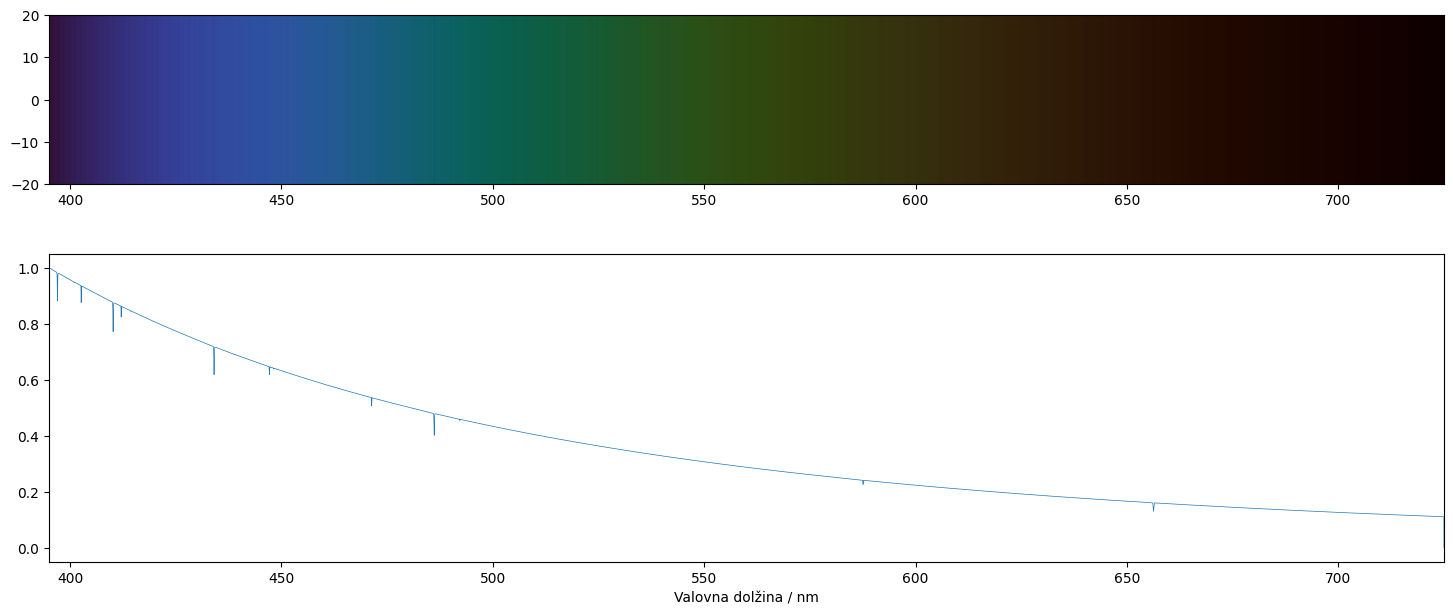

In [2]:
# Nalozimo datoteke

files_txt=['https://raw.githubusercontent.com/sheliak/klasifikacija_spektrov/main/primeri/O8_40600.txt',\
       'https://raw.githubusercontent.com/sheliak/klasifikacija_spektrov/main/primeri/B3_17600.txt',\
       'https://raw.githubusercontent.com/sheliak/klasifikacija_spektrov/main/primeri/A3_08750.txt',\
       'https://raw.githubusercontent.com/sheliak/klasifikacija_spektrov/main/primeri/F5_06700.txt',\
       'https://raw.githubusercontent.com/sheliak/klasifikacija_spektrov/main/primeri/G2_05800.txt',\
       'https://raw.githubusercontent.com/sheliak/klasifikacija_spektrov/main/primeri/K3_04800.txt',\
       'https://raw.githubusercontent.com/sheliak/klasifikacija_spektrov/main/primeri/M3_03500.txt']

files={40600: np.loadtxt(files_txt[0], comments='#', usecols=(0,1)),\
       17600: np.loadtxt(files_txt[1], comments='#', usecols=(0,1)),\
       8750: np.loadtxt(files_txt[2], comments='#', usecols=(0,1)),\
       6700: np.loadtxt(files_txt[3], comments='#', usecols=(0,1)),\
       5800: np.loadtxt(files_txt[4], comments='#', usecols=(0,1)),\
       4800: np.loadtxt(files_txt[5], comments='#', usecols=(0,1)),\
       3500: np.loadtxt(files_txt[6], comments='#', usecols=(0,1))}

# Narisimo spektre

c=3*10**8
p=3.1416
h=6.626*10**-34
k=1.38*10**-23
d=0.5*10**-1
A=2*c*c*h

def planck(x,t):
    return ((A)/(((x*10**-9)**5)*(np.exp(((h*c)/(t*k))/(x*10**-9))-1)))

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        clear_output()
        display(menu)
        fig=plt.figure(1)
        fig.subplots_adjust(hspace=0)
        ax1=fig.add_subplot(211)
        s=files[int(change['new'].split()[0])]
        l=s[:,0] # valovna dolzina
        w=s[:,1] # normaliziran flux
        t=int(change['new'].split()[0]) # temperatura
        wp=w*planck(l,t) # pravi flux
        wp=wp/max(wp) # pravi flux brez enot

        cmap_b=colors.LinearSegmentedColormap.from_list('cmap_b', ['k', 'k'])
        ax1.imshow(np.expand_dims(l, axis=0),cmap='turbo',extent=[l.min(), l.max(), -20,20],)
        ax1.imshow(np.expand_dims(wp, axis=0),alpha=np.expand_dims(1-wp, axis=0), cmap=cmap_b, extent=[l.min(), l.max(), -20,20],)
        ax2=fig.add_subplot(212, sharex=ax1)
        ax2.plot(l,wp, lw=0.5)
        ax2.set_xlabel('Valovna dolžina / nm')
        plt.show()

menu = Dropdown(options=['3500 K', '4800 K', '5800 K', '6700 K', '8750 K', '17600 K', '40600 K'], value='5800 K', description='Temperatura:')
menu.observe(on_change, names='value')
display(menu)


### Spektri zvezd

### Narišimo spekter

Za to vajo imamo na voljo spektre 10 000 različnih zvezd, ki jih je posnel pregled neba GALAH. Na voljo nam je del spektra z valovnimi dolžinami med 655.0 nm in 667.5 nm. Za 52 od teh zvezd imamo podane tudi podatke o temperaturi zvezde, gravitacijskem pospešku na njenem površju in zastopanost kovin v zvezdini atmosferi. Za ostale zvezde so ti parametri še neznani. Za 56 zvezd imamo podane njihove tipe (glej sledečo tabelo). Za ostale zvezde prav tako ne vemo kakšnih tipov so.

| Kratica | Tip zvezde | Lastnost |
| --- | --- | --- |
| MAB | Zvezde z molekularnimi črtami | V hladnejših zvezdah lahko preživijo preproste molekule, kot sta TiO in CN. te vidimo kot široke serije absorpcijskih črt ali pasov. |
| BIN | Dvojne zvezde | Zajeli smo svetlobo dveh zvezd in zato vidimo seštevek spektrov dveh zvezd. |
| TRI | Trojne zvezde | Vidimo seštevek treh spektrov treh zvezd. Posamezne zvezde so lahko različnih tipov. |
| HFR | Vroče, hitro se vrteče zvezde | Spektralne črte so močno razširjene. Šibkejših črt zato ne vidimo.|
| HAE | Spektri z emisijo v vodikovi H alpha črti. | Namesto absorpcijske črte vidimo emisijsko črto pri okoli 656 nm. Ali pa kombinacijo emisijske in absorpcijske črte.  |
| CMP | Hladne zvezde z malo kovinami | Absorpcijske črte kovin so šibke. Prav tako vodikova črta, saj so te zvezde hladne.|
| DIB | Prisotnost medzvezdnih absorpcijskih črt | Plin v prostoru med nami in zvezdo je dodal svoje absorpcijske črte, na primer okoli 661 nm. |

Za nekaj zvezd z znanimi tipi ali parametri narišimo njihov spekter. Številka spektra z znanim tipom ali parametri je podana v prvem stolpcu datotek `ucni_set_tipi.txt` in `ucni_set_parametri.txt`.

(6550.0, 6674.98)

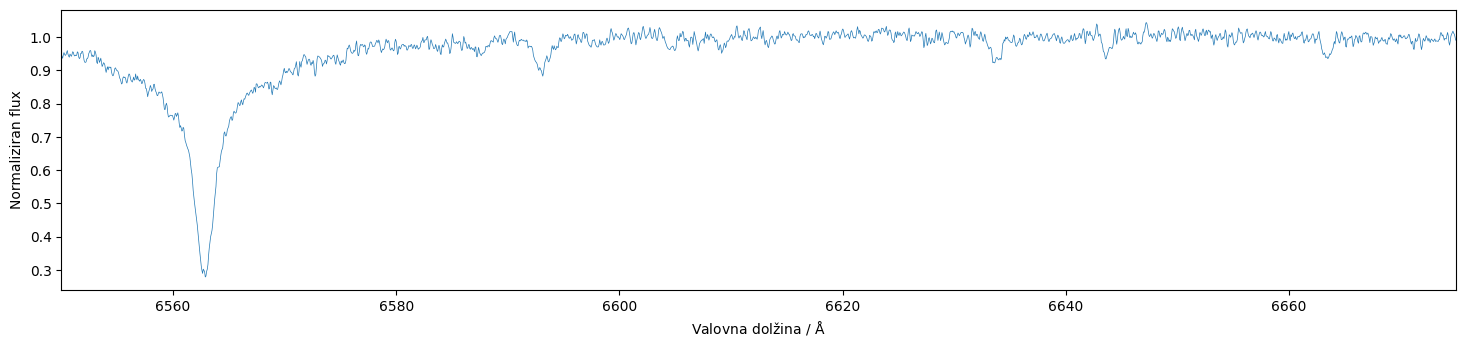

In [4]:
# Naredimo slovar tipov

tipi={}
for line in urllib.request.urlopen('https://raw.githubusercontent.com/sheliak/klasifikacija_spektrov/main/podatki/ucni_set_tipi.txt'):
    line=line.decode('utf-8')
    if line[0]=='#': continue
    spekter, tip = line.split()
    if tip in tipi:
        tipi[tip].append(spekter)
    else:
        tipi[tip]=[spekter]

# Narisimo spekter nekega tipa ('MAB', 'BIN', 'TRI', 'HFR', 'HAE', 'CMP', 'DIB')

spekter=tipi['HFR'][0]
l=np.loadtxt('https://raw.githubusercontent.com/sheliak/klasifikacija_spektrov/main/podatki/spektri/val.dat') # seznam valovnih dolzin
w = np.loadtxt('https://raw.githubusercontent.com/sheliak/klasifikacija_spektrov/main/podatki/spektri/%s.dat' % spekter) # flux

fig=plt.figure(2)
ax=fig.add_subplot(211)
ax.plot(l,w,lw=0.5)
ax.set_xlabel('Valovna dolžina / $\mathrm{\AA}$')
ax.set_ylabel('Normaliziran flux')
ax.set_xlim(l[0], l[-1])

In [5]:


# Narisimo vse spektre nekega tipa

def plot_all(spekter_bold=0):
    #spekter_bold pove kateri spekter iz enega tipa naj bo povdarjen
    fig=plt.figure(3)
    ax=fig.add_subplot(211)

    tip=menu.value #kateri tip risem

    spectra=[]
    #narisi vse spektre v sivem
    ax.cla()
    for spekter in tipi[tip]:
        w = np.loadtxt('https://raw.githubusercontent.com/sheliak/klasifikacija_spektrov/main/podatki/spektri/%s.dat' % spekter)
        spectra.append(w)
        ax.plot(l,w,lw=0.6, alpha=0.2, c='k')
    #narisi povdarjen spekter
    ax.plot(l,spectra[spekter_bold], lw=0.6, alpha=1, c='r')
    ax.set_xlabel('Valovna dolžina / $\mathrm{\AA}$')
    ax.set_ylabel('Normaliziran flux')
    ax.set_title('Spekter # '+tipi[tip][spekter_bold])
    ax.set_xlim(l[0], l[-1])
    plt.show()

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        clear_output()
        display(menu)
        w=interactive(plot_all, spekter_bold=(0,len(tipi[menu.value])-1,1))
        display(w)

menu = Dropdown(options=['MAB', 'BIN', 'TRI', 'HFR', 'HAE', 'CMP', 'DIB'], value='MAB', description='Tip:')
menu.observe(on_change, names='value')
display(menu)

w=interactive(plot_all, spekter_bold=(0,len(tipi[menu.value])-1,1))
w


Dropdown(description='Tip:', index=1, options=('MAB', 'BIN', 'TRI', 'HFR', 'HAE', 'CMP', 'DIB'), value='BIN')

interactive(children=(IntSlider(value=0, description='spekter_bold', max=7), Output()), _dom_classes=('widget-…

Vidimo, da v večini primerov brez učnega seta sploh ne moremo ugotoviti, kakšnega tipa so te zvezde. Na primer, večina dvojnih zvezd nima podvojenih črt. Vidimo le eno od komponent, ali pa so črte primarne in sekundarne zvezde zlite skupaj.

Katerega tipa so zvezde bo veliko bolje od naših uči ugotovil računalnik.

<a id='pca'></a>
## Metoda glavnih komponent

### Projekcije v mnogo dimenzijah

Mogoče ste že ugotovili, da imajo vsi naši spektri podan fluks pri istih 2084 valovnih dolžinah v konstantnih korakih 0.006 nm. Temu rečemo vzorčenje. Posledično je vsak spekter podan le z 2084 vrednostmi fluksa pri vsaki valovni dolžini. Sedaj bomo vsak spekter predstavili kot točko v 2084 dimenzionalnem prostoru ali kot vektor v 2084 dimenzionalnem prostoru. To si je mogoče težko predstavljati, vendar računalniki so prilagojeni delu z vektorji v visokodimenzionalnih prostorih.

Za boljšo predstavo postavimo spektre na stran in si poglejmo set podatkov, kjer ima vsaka točka le dve koordinati (v 2D prostoru).

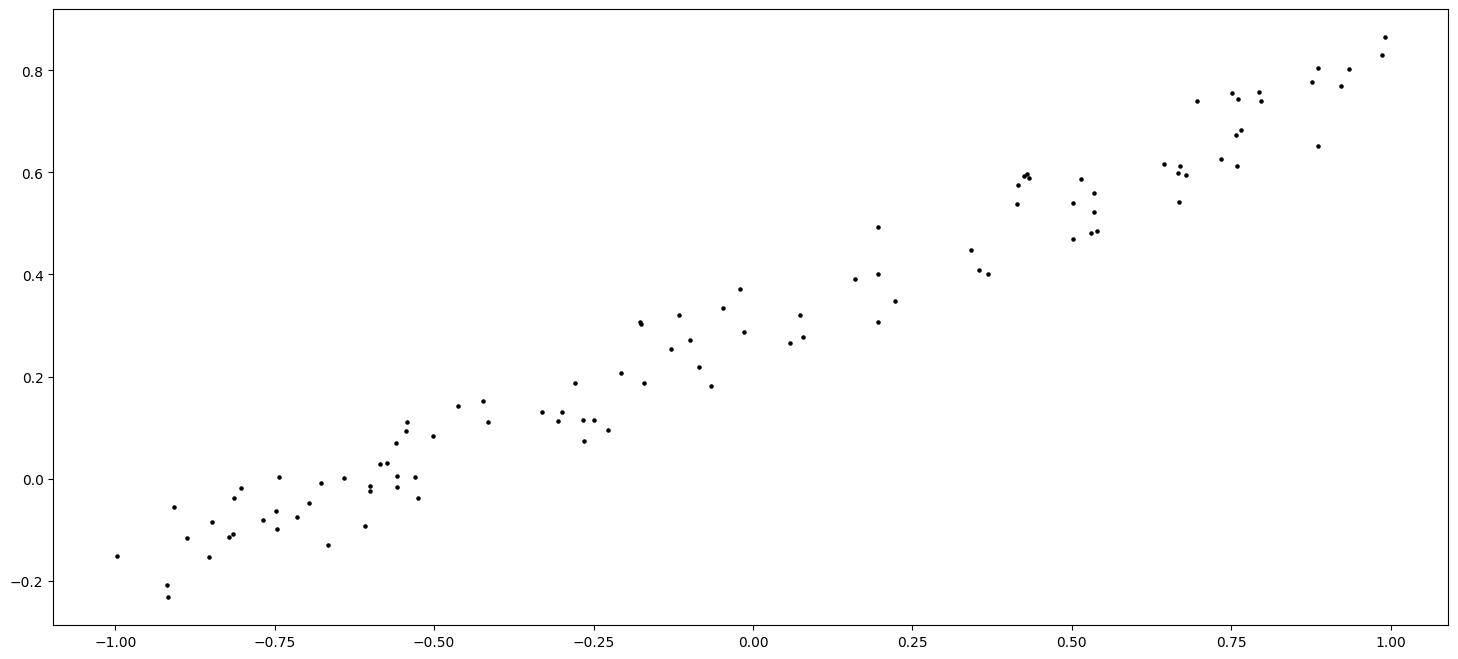

In [6]:
# Generirajmo 2D podatke

x=np.random.rand(100)*2-1
y=0.5*x+0.3+np.random.rand(100)*0.2-0.1

fig=plt.figure(4)
ax=fig.add_subplot(111)
ax.scatter(x,y,s=5,c='k')
plt.show()

Vidimo, da vzgornjem primeru vse točke ležijo vzdolž neke premice z relativno majhno razsutostjo. Izberimo si dve točki. Da lahko povemo kako sta si podobni ali različni, moramo vsako točko opisati z dvema koordinatama. Ampak relacijo med obema točkama prav dobro opišemo, če povemo le kako daleč narazen sta si vzdolž premice.

Izračunamo lahko projekcijo točk na premico. Pozicijo vsake točke na tej premici bomo sedaj lahko podali z le eno koordinato. Dimenzijo naših podatkov smo tako zreducirali iz dveh na eno. Pri tem so se (v večji meri) ohranile relacije med točkami: dve točki, ki sta bili daleč narazen v 2D prostoru sta daleč narazen tudi v 1D prostoru.

In [7]:
# Generirajmo 2D podatke

x=np.random.rand(100)*2-1
y=0.5*x+0.3+np.random.rand(100)*0.2-0.1

def plot_me(pa=0, pb=1):
    global x
    global y
    fig=plt.figure(5)
    ax=fig.add_subplot(111)
    ax.scatter(x,y,s=5,c='k')
    ax.plot(x[pa],y[pa],'ro')
    ax.text(x[pa], y[pa], ' A', c='r')
    ax.plot(x[pb], y[pb], 'ro')
    ax.text(x[pb], y[pb], ' B', c='r')
    xx=np.linspace(-1,1)
    yy=0.5*xx+0.3
    ax.plot(xx,yy)

    # Projecirajmo tocke na premico
    premica=[1,0.5] # vektor, ki podaja premico
    xn=x-np.average(x)
    yn=y-0.3
    projekcija=[np.dot(premica, [i, j])/np.sqrt(1+0.5**2) for i,j in zip(xn,yn)]
    fig=plt.figure(6)
    ax=fig.add_subplot(311)
    ax.scatter(projekcija, [0]*len(projekcija),s=5,c='k')
    ax.plot(projekcija[pa], 0,'ro')
    ax.text(projekcija[pa], 0, ' A', c='r')
    ax.plot(projekcija[pb], 0, 'ro')
    ax.text(projekcija[pb], 0, ' B', c='r')
    plt.show()

w=interactive(plot_me, pa=(0,100,1), pb=(0,100,1))
w

interactive(children=(IntSlider(value=0, description='pa'), IntSlider(value=1, description='pb'), Output()), _…

Cilj te naloge je na podoben način zreducirati naš 2084 dimenzionalni prostor na 2D prostor, kjer lahko položaj vsakega spektra še vedno predstavimo s točko v dveh dimenzijah. Če lahko projekcije naredimo na tak način, da se bodo relacije med točkami v 2084D prostoru čim bolje ujemale z relaciji med točkami v 2D prostoru, bomo lahko sklepali, da so spektri na istem delu 2D ravnine podobni.

V praksi seveda ne vemo vzdolž katere ravnine moramo narediti projekcijo. To lahko ugotovimo z metodo glavnih komponent (ang. Principal component analysis - PCA).

Poglejmo najprej ali metoda PCA da pričakovan rezultat za naš preprost sistem 2D podatkov. Naredimo PCA redukcijo iz dveh dimenzij v eno:

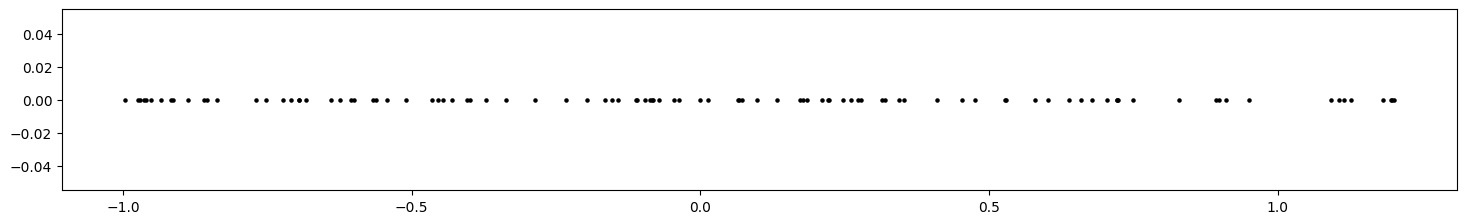

In [8]:
pca = PCA(n_components=1)
pca.fit(np.array([x,y]).T)
projekcija=pca.transform(np.array([x,y]).T)

fig=plt.figure(0)
ax=fig.add_subplot(311)
ax.scatter(projekcija, [0]*len(projekcija),s=5,c='k')
plt.show()

Odprimo sedaj vse spektre in naredimo njihovo projekcijo iz 2084 dimenzij v dve:

In [9]:
#Nalozimo vse spektre (lahko traja)
spektri=[]
l=np.loadtxt('https://raw.githubusercontent.com/sheliak/klasifikacija_spektrov/main/podatki/spektri/val.dat') # seznam valovnih dolzin
for i in range(1,5300,1):
    print('Procesiram spekter st. %s' % i, end='')
    w = np.loadtxt('https://raw.githubusercontent.com/sheliak/klasifikacija_spektrov/main/podatki/spektri/%s.dat' % i) # flux
    spektri.append(w)
    print('\r', end='')

#Pretvorimo seznam v array
spektri=np.array(spektri)



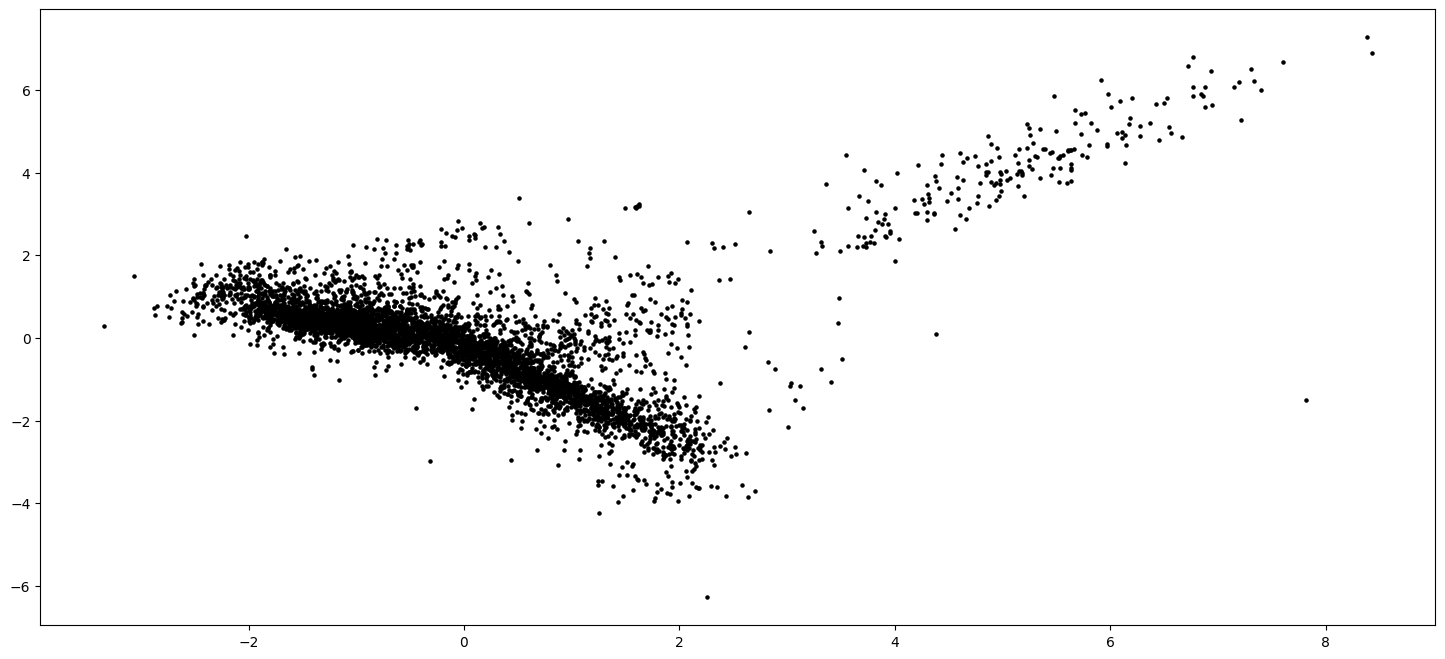

In [10]:
#Naredimo projekcijo
pca = PCA(n_components=2)
pca.fit(spektri)
projekcija=pca.transform(spektri)

#Narisemo 2D ravnino
fig=plt.figure(1)
ax=fig.add_subplot(111)
ax.scatter(projekcija[:,0], projekcija[:,1], s=5, c='k')
plt.show()

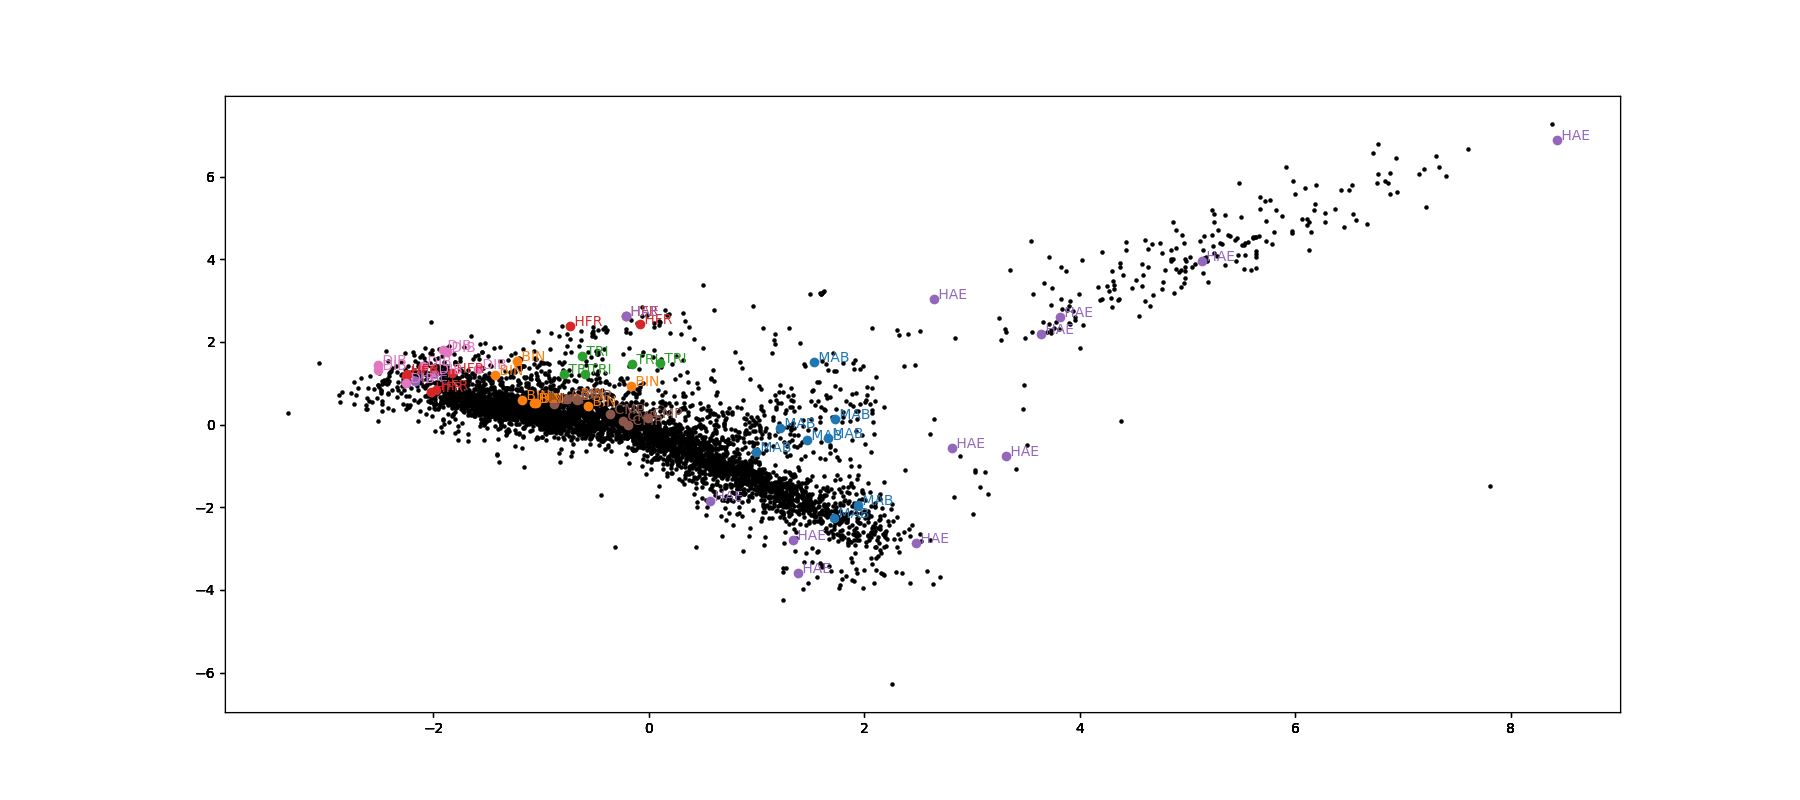

AttributeError: ignored

AttributeError: ignored

AttributeError: ignored

AttributeError: ignored

In [17]:
!pip -q install ipympl
from google.colab import output
output.enable_custom_widget_manager()
%matplotlib ipympl

def on_click(event):
    ix, iy = event.xdata, event.ydata
    print(ix, iy)

#Naredimo projekcijo
pca = PCA(n_components=2)
pca.fit(spektri)
projekcija=pca.transform(spektri)

#Narisemo 2D ravnino
fig=plt.figure(1)
ax=fig.add_subplot(111)
ax.scatter(projekcija[:,0], projekcija[:,1], s=5, c='k', picker=10)

fig.canvas.callbacks.connect('button_press_event', on_click)

#Dodamo oznake za zvezde iz ucnega seta ('MAB', 'BIN', 'TRI', 'HFR', 'HAE', 'CMP', 'DIB')

for n,tip in enumerate(['MAB', 'BIN', 'TRI', 'HFR', 'HAE', 'CMP', 'DIB']):
    indexes=tipi[tip]
    for i in indexes:
        ax.plot(projekcija[:,0][int(i)-1], projekcija[:,1][int(i)-1], marker='o', c='C%s' % n)
        ax.text(projekcija[:,0][int(i)-1], projekcija[:,1][int(i)-1], ' '+tip, c='C%s' % n)

plt.show()

<a id='tsne'></a>
## Nelinearne projekcije

V praksi se podatki le redko uredijo vzdolž ravnin, zato linearne projekcije navadno ne ohranjajo relacij med točkami v mnogodimenzionalnem prostoru in 2D prostoru. Poslužiti se moramo nelinearnih projekcij. Spoznali bomo metodo t-distributed stohastic neigbour embedding (t-SNE).

Nelinearne metode za vsako to;ko v originalnem prostoru ugotovijo kakšna je njihova relacija glede na njihove najbližje sosede. Potem sestavijo prostor nižjih dimenzij in ga poselijo s točkami tako, da se podobnosti med sosedi najbolje ohranjajo.